In [8]:
# -
#
# SPDX-FileCopyrightText: Copyright (c) 2024 Pietro Carlo Boldini, Rene Pecnik and the CUBENS contributors. All rights reserved.
# SPDX-License-Identifier: MIT
#
# -

import numpy as np

from scipy.sparse.linalg import spsolve
from scipy.sparse        import diags, hstack, vstack
from scipy import interpolate as int1d

import CoolProp.CoolProp as CP
import os
CP.set_config_string(CP.ALTERNATIVE_REFPROP_PATH, '/Users/rpecnik/Documents/REFPROP10.0')

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rcParams.update({'font.size': 18})
rcParams['figure.figsize']   = [8,6]
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family']      = 'STIXGeneral'

kelvin = 273.15

# Define reference conditions
For example, for the boundary layer specify the freestream condition and the the temperature at the wall. These conditions can then be used to plot in the table, to check where these copnditions are located in the final tables. 

non-dim:
\begin{gather}
u=\frac{u^{*}}{u_{\infty}^{*}},~
a=\frac{a^{*}}{u_{\infty}^{*}},~
p=\frac{p^{*}}{\rho_{\infty}^{*}u_{\infty}^{*2}},~
\rho=\frac{\rho^{*}}{\rho_{\infty}^{*}},~\nonumber \\
T=\frac{T^{*}}{T_{\infty}^{*}},~
E=\frac{E^{*}}{u_{\infty}^{*2}},~
\mu=\frac{\mu^{*}}{\mu_{\infty}^{*}},~
\kappa=\frac{\kappa^{*}}{\kappa_{\infty}^{*}},
\end{gather}

Non-dim. number:
\begin{equation}\label{Re}
Re_\infty=\frac{\rho_{\infty}^{*}u_{\infty}^{*}l_0^{*}}{\mu_{\infty}^{*}},~
Pr_\infty=\frac{\mu_{\infty}^{*}C_{p\infty}^{*}}{\kappa_{\infty}^{*}},~
Ec_\infty=\frac{u_{\infty}^{*2}}{C_{p\infty}^{*}T_{\infty}^{*}},~
Ma_\infty=\frac{u_{\infty}^{*}}{a^*_\infty}.
\end{equation}

Table non-dim:
$$\rho=\frac{\rho^{*}}{\rho_{\infty}^{*}}, ~
p=\frac{p^{*}}{\rho_{\infty}^{*} c_{p\infty}^{*} T_{\infty} Ec }, ~
E=\frac{E^{*}}{ c_{p\infty}^{*} T_{\infty} Ec }, ~
a=\frac{a^*}{a^*_\infty }\frac{1}{Ma}, ~
fac = \frac{c_p^*}{\alpha_v^*}
$$

# Get freestream conditions

In [9]:
class refValues():
    def __init__(self,params):
        
        self.flu = params['fluid']

        self.tem = params['T_inf']
        self.pre = params['P_inf']
        
        ALV = "ISOBARIC_EXPANSION_COEFFICIENT"
        self.rho = CP.PropsSI('D', "T", self.tem, "P", self.pre, self.flu)
        self.ien = CP.PropsSI('U', "T", self.tem, "P", self.pre, self.flu)
        self.cp  = CP.PropsSI('C', "T", self.tem, "P", self.pre, self.flu)
        self.mu  = CP.PropsSI('V', "T", self.tem, "P", self.pre, self.flu)
        self.ka  = CP.PropsSI('L', "T", self.tem, "P", self.pre, self.flu)
        self.sos = CP.PropsSI('A', "T", self.tem, "P", self.pre, self.flu)
        self.alv = CP.PropsSI(ALV, "T", self.tem, "P", self.pre, self.flu)
        

        self.vel    = (self.cp*params['T_inf']*params['Ec'])**0.5 
        self.Ma     = self.vel/self.sos
        self.Re     = params['Re']
        self.Pr     = CP.PropsSI('Prandtl', "T", self.tem, "P", self.pre, self.flu)
        self.RePrEc = self.Re*self.Pr*params['Ec']

        print("rho_inf  = ", self.rho)
        print("ien_inf  = ", self.ien)
        print("ien_wall = ", CP.PropsSI('U', "T", params['T_wall'], "P", self.pre, self.flu))
        print("cp_inf   = ", self.cp)
        print("mu_inf   = ", self.mu)
        print("ka_inf   = ", self.ka)
        print("a_inf    = ", self.sos)
        print("Pr_inf   = ", self.Pr)
        print("cp/alfav = ", self.cp/self.alv)
        

        print('\nu_inf  = ', self.vel)
        print("Ma_inf   = ", self.Ma)

        print('p_inf_nD = ', self.pre/(self.rho*self.vel**2))



# Code for the $\rho - e$ table

In [43]:
class RE_table():

    def __init__(self, fluid, Tmin=270.0, Tmax=330.0, Pmin=75e5, Pmax=90e5, 
                 imax=20, jmax=10, jOffset=4, diagTable=True, e_ref = 1e5):

        self.fluid = fluid
        
        self.e_ref = e_ref

        # stuff for saturation lines in plots
        pcrit = CP.PropsSI('pcrit', fluid)
        tcrit = CP.PropsSI('Tcrit', fluid)
        rcrit = CP.PropsSI('D', 'P', pcrit, 'T', tcrit, fluid)
        ecrit = CP.PropsSI('U', 'P', pcrit, 'T', tcrit, fluid) - self.e_ref

        self.p_sat   = np.linspace(pcrit*0.1, pcrit, 400)
        self.T_sat   = CP.PropsSI('T', "P", self.p_sat, "Q", 0.0, fluid)
        self.rho_liq = CP.PropsSI('D', "P", self.p_sat, "Q", 0.0, fluid)
        self.rho_vap = CP.PropsSI('D', "P", self.p_sat, "Q", 1.0, fluid)
        self.ien_liq = CP.PropsSI('U', "P", self.p_sat, "Q", 0.0, fluid) - self.e_ref
        self.ien_vap = CP.PropsSI('U', "P", self.p_sat, "Q", 1.0, fluid) - self.e_ref

        rhoSat = np.concatenate([self.rho_liq, self.rho_vap[-2:0:-1]])
        ienSat = np.concatenate([self.ien_liq, self.ien_vap[-2:0:-1]])
        f = int1d.interp1d(rhoSat, ienSat)
        
        if diagTable == True:
            self.rho_1d, self.ien_1d = self.getAxisTableRhoE(fluid, Tmin, Tmax, Pmin, Pmax, imax, imax)
        else:
            self.rho_1d, self.ien_1d = self.getAxisTableRhoE(fluid, Tmin, Tmax, Pmin, Pmax, imax, jmax)

        self.ienSat_1d = f(self.rho_1d)
        self.makeTable(fluid, self.rho_1d, self.ien_1d, imax, jmax, jOffset, diagTable)


    def getAxisTableRhoE(self, fluid, Tmin, Tmax, Pmin, Pmax, imax, jmax):
        
#         r1 = CP.PropsSI('D', "T", Tmin, "P", Pmin, fluid) #; print('rho 1 = ', r1)
        r2 = CP.PropsSI('D', "T", Tmin, "P", Pmax, fluid); print('rho 2 = ', r2)
        r3 = CP.PropsSI('D', "T", Tmax, "P", Pmin, fluid); print('rho 3 = ', r3)
#         r4 = CP.PropsSI('D', "T", Tmax, "P", Pmax, fluid) #; print('rho 4 = ', r4)

#         e1 = CP.PropsSI('U', "T", Tmin, "P", Pmin, fluid) #; print('ien 1 = ', e1)
        e2 = CP.PropsSI('U', "T", Tmin, "P", Pmax, fluid) - self.e_ref; print('ien 2 = ', e2)
        e3 = CP.PropsSI('U', "T", Tmax, "P", Pmin, fluid) - self.e_ref; print('ien 3 = ', e3)
#         e4 = CP.PropsSI('U', "T", Tmax, "P", Pmax, fluid) #; print('ien 4 = ', e4,'\n')

        return np.linspace(r2, r3, imax), np.linspace(e2, e3, jmax)

    
    def makeTable(self, fluid, rho_1d, ien_1d, imax, jmax, jOffset, diagTable):
        
        self.rho = np.outer(rho_1d.T, np.ones(jmax))
        self.ien = np.zeros((imax, jmax))

        self.pre = np.zeros((imax, jmax))
        self.tem = np.zeros((imax, jmax))
        self.sos = np.zeros((imax, jmax))
        self.fac = np.zeros((imax, jmax))
        
        self.der = np.zeros((imax, jmax))

        self.vis    = np.zeros((imax, jmax))
#         self.dvisdT = np.zeros((imax, jmax))
#         self.dvisdr = np.zeros((imax, jmax))

        self.con    = np.zeros((imax, jmax))
#         self.dcondT = np.zeros((imax, jmax))
#         self.dcondr = np.zeros((imax, jmax))

        epsTemp = 1.0e-2
        epsRho  = 1.0e-2
        
        ALV = 'ISOBARIC_EXPANSION_COEFFICIENT'

        for i,r in enumerate(self.rho_1d):
            for j in range(jmax):

                if diagTable == True: 
                    e = ien_1d[i] + (j-jOffset)*(ien_1d[1]-ien_1d[0])
                else:
                    e = ien_1d[j]

                self.ien[i,j] = e 
                
                if e > self.ienSat_1d[i]:
                    try:
                        self.pre[i,j] = CP.PropsSI('P', "D", r, "U", e + self.e_ref, fluid)
                        self.tem[i,j] = CP.PropsSI('T', 'D', r, "U", e + self.e_ref, fluid)

                        rho1  = r 
                        rho2  = r + epsRho

                        temp1 = self.tem[i,j]
                        temp2 = temp1 + epsTemp

                        self.sos[i,j] = CP.PropsSI("A", "D", r, "U", e + self.e_ref, fluid)
                        cp            = CP.PropsSI('C', "D", r, "U", e + self.e_ref, fluid)
                        alv           = CP.PropsSI(ALV, "D", r, "U", e + self.e_ref, fluid)
                        self.fac[i,j] = cp/alv
                        
                        self.der[i,j] = r*( CP.PropsSI("U","D",rho2,"P",self.pre[i,j],fluid) 
                                           -CP.PropsSI("U","D",rho1,"P",self.pre[i,j],fluid) )/epsRho
                        

                        self.vis[i,j]    =  CP.PropsSI("V","D",rho1,"T",temp1,fluid)
#                         self.dvisdT[i,j] = (CP.PropsSI("V","D",rho1,"T",temp2,fluid)-self.vis[i,j])/epsTemp
#                         self.dvisdr[i,j] = (CP.PropsSI("V","D",rho2,"T",temp1,fluid)-self.vis[i,j])/epsRho

                        self.con[i,j]    =  CP.PropsSI("L","D",rho1,"T",temp1,fluid)
#                         self.dcondT[i,j] = (CP.PropsSI("L","D",rho1,"T",temp2,fluid)-self.con[i,j])/epsTemp
#                         self.dcondr[i,j] = (CP.PropsSI("L","D",rho2,"T",temp1,fluid)-self.con[i,j])/epsRho
                    except:
                        print("errror in tabulating")
                        

        if diagTable == True:
            self.ien_1d = np.concatenate([self.ien[:,0],self.ien[-1,1:]])

            
    def nonDimensionalize(self, inf):
        self.rho_1d = ( self.rho_1d / inf.rho    )
        self.ien_1d = ( self.ien_1d / inf.vel**2 )
        
        self.rho = ( self.rho / inf.rho    )
        self.ien = ( self.ien / inf.vel**2 )

        self.pre = ( self.pre / (inf.rho*inf.vel**2) )
        self.tem = ( self.tem / inf.tem              )
        self.sos = ( self.sos / (inf.vel)            )
        self.fac = ( self.fac / (inf.vel**2.0)       )

        self.vis    = ( self.vis    / inf.mu/inf.Re         )
#         self.dvisdT = ( self.dvisdT / inf.mu*inf.tem/inf.Re )
#         self.dvisdr = ( self.dvisdr / inf.mu*inf.rho/inf.Re )

        self.con    = ( self.con    / inf.ka/inf.RePrEc         )
#         self.dcondT = ( self.dcondT / inf.ka*inf.tem/inf.RePrEc )
#         self.dcondr = ( self.dcondr / inf.ka*inf.rho/inf.RePrEc )


    def saveTable(self, inf):
            
        ( self.rho_1d / inf.rho  ).tofile("RE_tab_1d_rho.bin")
        ( self.ien_1d / inf.vel**2 ).tofile("RE_tab_1d_ien.bin")

        ( self.pre / (inf.rho*inf.vel**2) ).tofile("RE_tab_2d_pre.bin")
        ( self.tem / inf.tem              ).tofile("RE_tab_2d_tem.bin")
        ( self.sos / (inf.vel)            ).tofile("RE_tab_2d_sos.bin")
        ( self.fac / (inf.vel**2.0)       ).tofile("RE_tab_2d_fac.bin")
        
        ( self.der / (inf.vel**2.0)       ).tofile("RE_tab_2d_der.bin")

        ( self.vis    / inf.mu/inf.Re         ).tofile("RE_tab_2d_vis.bin")
#         ( self.dvisdT / inf.mu*inf.tem/inf.Re ).tofile("RE_tab_2d_dmudT.bin")
#         ( self.dvisdr / inf.mu*inf.rho/inf.Re ).tofile("RE_tab_2d_dmudr.bin")

        ( self.con    / inf.ka/inf.RePrEc         ).tofile("RE_tab_2d_con.bin")
#         ( self.dcondT / inf.ka*inf.tem/inf.RePrEc ).tofile("RE_tab_2d_dkadT.bin")
#         ( self.dcondr / inf.ka*inf.rho/inf.RePrEc ).tofile("RE_tab_2d_dkadr.bin")
        
    def saveTableDimensional(self, inf):
            
        ( self.rho_1d).tofile("RE_tab_1d_rho.bin")
        ( self.ien_1d).tofile("RE_tab_1d_ien.bin")

        ( self.pre).tofile("RE_tab_2d_pre.bin")
        ( self.tem).tofile("RE_tab_2d_tem.bin")
        ( self.sos).tofile("RE_tab_2d_sos.bin")
        ( self.fac).tofile("RE_tab_2d_fac.bin")

        ( self.vis).tofile("RE_tab_2d_vis.bin")
#         ( self.dvisdT).tofile("RE_tab_2d_dmudT.bin")
#         ( self.dvisdr).tofile("RE_tab_2d_dmudr.bin")

        ( self.con).tofile("RE_tab_2d_con.bin")
#         ( self.dcondT).tofile("RE_tab_2d_dkadT.bin")
#         ( self.dcondr).tofile("RE_tab_2d_dkadr.bin")


    def plotTable_RE(self, fig, ax, T_inf, T_wall, P_inf, val, plotMesh, vmin=None, vmax=None):

        fluid = self.fluid 

        # contour of a variable
        m = ax.contourf(self.rho, self.ien, val, 20, cmap="jet", vmin=vmin, vmax=vmax)
        fig.colorbar(m, ax=ax)
        
        # saturation lines and critical point
        ax.plot(self.rho_liq,     self.ien_liq,     'g-',  lw=3, label="sat. liquid")
        ax.plot(self.rho_vap,     self.ien_vap,     'g--', lw=3, label="sat. vapor")
        ax.plot(self.rho_liq[-1], self.ien_liq[-1], 'go',ms=10)

        # Mesh of the table
        if plotMesh: 
            ax.plot(self.rho.T, self.ien.T, 'go', lw=0.5,ms=2)
        
        # reference conditions of boundary layer
        T_BL = np.linspace(T_inf, T_wall, 100)
        r_BL = CP.PropsSI('D', 'P', P_inf, 'T', T_BL, fluid)
        e_BL = CP.PropsSI('U', 'P', P_inf, 'T', T_BL, fluid) - self.e_ref
        ax.plot(r_BL,     e_BL,     'b-',lw=3,  label="Boundary layer distribution")
        ax.plot(r_BL[0] , e_BL[0],  'bo',ms=10, label="Boundary layer freestream")
        ax.plot(r_BL[-1], e_BL[-1], 'bP',ms=10, label="Boundary layer wall")
        
        ax.legend(); ax.set_xlabel('rho'); ax.set_ylabel('ien'); 
        ax.set_xlim((self.rho_1d[-1]*0.93, self.rho_1d[0]*1.02))
        
        
    def plotTable_pv(self, fig, ax, T_inf, T_wall, P_inf, val, plotMesh):
        
        fluid = self.fluid

        m = ax.contourf(np.log(1/self.rho), np.log(self.pre), val, 20, cmap="cool")
        fig.colorbar(m, ax=ax)

        if plotMesh:
            ax.plot(np.log(1/self.rho),   np.log(self.pre),   'k', lw=0.5)
            ax.plot(np.log(1/self.rho.T), np.log(self.pre.T), 'k', lw=0.5)

        # saturation lines and critical point
        ax.plot(np.log(1/self.rho_liq),     np.log(self.p_sat),     'g-',  lw=3, label="sat. liquid")
        ax.plot(np.log(1/self.rho_vap),     np.log(self.p_sat),     'g--', lw=3, label="sat. vapor")
        ax.plot(np.log(1/self.rho_vap[-1]), np.log(self.p_sat[-1]), 'go',  ms=10)

        # reference conditions of boundary layer
        T_BL = np.linspace(T_inf, T_wall, 100)
        ax.plot(np.log(1.0/CP.PropsSI('D', 'P', P_inf, 'T', T_BL, fluid)), 
                 np.log(P_inf*np.ones(T_BL.size)), 'b-',lw=3, label="Boundary layer states")
        ax.plot(np.log(1.0/CP.PropsSI('D', 'P', P_inf, 'T', T_BL[0], fluid)), 
                 np.log(P_inf), 'bo',ms=10, label="Boundary layer freestream")
        ax.plot(np.log(1.0/CP.PropsSI('D', 'P', P_inf, 'T', T_BL[-1], fluid)), 
                 np.log(P_inf), 'b>',ms=10, label="Boundary layer wall")
        
        ax.legend(); ax.set_xlabel('v'); ax.set_ylabel('pre'); 
        ax.set_xlim((np.log(1/self.rho_1d[0]*0.93), np.log(1/self.rho_1d[-1]*1.02)))

        
    def plotTable_PT(self, fig, plt, T_inf, T_wall, P_inf, val, plotMesh):
        fluid = self.fluid

        m = ax.contourf(self.tem, self.pre, val, 20, cmap="cool")
#         m = ax.contourf(self.tem, np.log(self.pre), val, 20,cmap="cool")
        fig.colorbar(m, ax=ax)

        if plotMesh:
            ax.plot(self.tem,   self.pre,   'k', lw=0.5)
            ax.plot(self.tem.T, self.pre.T, 'k', lw=0.5)
#             ax.plot(self.tem,   np.log(self.pre),   'k', lw=0.5)
#             ax.plot(self.tem.T, np.log(self.pre.T), 'k', lw=0.5)

        # saturation lines and critical point
        ax.plot(self.T_sat,     self.p_sat,     'b', lw=3)
        ax.plot(self.T_sat[-1], self.p_sat[-1], 'ob')

        # reference conditions of boundary layer
#         ax.plot([T_inf, T_wall], np.log(P_inf*np.ones(2)), 'r-',lw=3, label="Boundary layer states")
        
        ax.legend(); ax.set_xlabel('Temperature'); ax.set_ylabel('Pressure');
#         ax.set_xlim([270,330]);  ax.set_ylim([15.5,16.5]);        

# Code for $P-T$ table

In [44]:
def make_PT_Table(imax, jmax, Pmin, Pmax, Tmin, Tmax, e_ref = 0.0):
    
    pre_1d = np.linspace(Pmin, Pmax, imax)
    tem_1d = np.linspace(Tmin, Tmax, jmax)
    pre,tem = np.meshgrid(pre_1d, tem_1d, indexing='ij')
    rho = np.zeros((imax, jmax))
    ien = np.zeros((imax, jmax))
    vis = np.zeros((imax, jmax))
    con = np.zeros((imax, jmax))

    for i,p in enumerate(pre_1d):
        rho[i,:] = CP.PropsSI('D', "P", p, "T", tem_1d, params['fluid'])
        ien[i,:] = CP.PropsSI('U', "P", p, "T", tem_1d, params['fluid']) - e_ref
        vis[i,:] = CP.PropsSI('V', "P", p, "T", tem_1d, params['fluid'])
        con[i,:] = CP.PropsSI('L', "P", p, "T", tem_1d, params['fluid'])

    ( pre_1d / (inf.rho*inf.vel**2.0) ).tofile("PT_tab_1d_pre.bin")
    ( tem_1d / inf.tem                ).tofile("PT_tab_1d_tem.bin")
    ( rho    / inf.rho                ).tofile("PT_tab_2d_rho.bin")
#     ( ien    / inf.vel**2             ).tofile("PT_tab_2d_ien.bin")
#     ( vis    / inf.mu/inf.Re          ).tofile("PT_tab_2d_vis.bin")
#     ( con    / inf.ka/inf.RePrEc      ).tofile("PT_tab_2d_con.bin")

    fig, ax = plt.subplots(1,1,figsize=(14,6))
    plt.contourf(tem, pre, rho, 20, cmap = "jet")
    plt.colorbar()
    plt.plot(tem, pre,     'k', lw=0.5)
    plt.plot(tem.T, pre.T, 'k', lw=0.5)
    plt.plot([params['T_inf'], params['T_wall']], params['P_inf']*np.ones(2), 'k-',lw=3, label="BL states")

    return rho

# Make $\rho-T$ table

In [45]:
def make_rT_Table(rho_1d, imax,jmax, Tmin,Tmax, e_ref = 0.0):
    
    tem_1d  = np.linspace(Tmin, Tmax, jmax)
    rho,tem = np.meshgrid(rho_1d, tem_1d, indexing='ij')
    ien = np.zeros((imax, jmax))
    pre = np.zeros((imax, jmax))
    for i,r in enumerate(rho_1d):
        ien[i,:] = CP.PropsSI('U', "D", r, "T", tem_1d, params['fluid'])-e_ref
        pre[i,:] = CP.PropsSI('P', "D", r, "T", tem_1d, params['fluid'])

    ( rho_1d / inf.rho    ).tofile("RT_tab_1d_rho.bin")
    ( tem_1d / inf.tem    ).tofile("RT_tab_1d_tem.bin")
    ( ien    / inf.vel**2 ).tofile("RT_tab_2d_ien.bin")


    fig, ax = plt.subplots(1,1,figsize=(14,10))
    plt.contourf(rho, tem, pre, 20, cmap="jet")
    plt.plot(rho,   (tem),   'k', lw=0.5)
    plt.plot(rho.T, (tem.T), 'k', lw=0.5)
    plt.colorbar()

    # reference conditions of boundary layer
    T_bl = np.linspace( params['T_inf'], params['T_wall'], 100)
    plt.plot(CP.PropsSI('D', 'P', params['P_inf'], 'T', T_bl, params['fluid']), T_bl,   
                'k-', lw=3, label="Boundary layer distribution")

# Tables for P=85 case

In [46]:
params = {'fluid' : 'REFPROP::CO2', 
          'Ec'    : 0.01, 
          'P_inf' : 85.0e5, 
          'T_inf' : 294.9593531839261, 
          'T_wall': 326.0077061506552,
          'Re'    : 1297.6103265991546}

inf = refValues(params)

rho_inf  =  819.9521552425888
ien_inf  =  -266177.9569332423
ien_wall =  -108918.29026150661
cp_inf   =  2992.5114139164075
mu_inf   =  7.514852047517787e-05
ka_inf   =  0.09081892203670161
a_inf    =  423.21532110319214
Pr_inf   =  2.4761668627824203
cp/alfav =  271404.679101672

u_inf  =  93.95047796814553
Ma_inf   =  0.22199214745639534
p_inf_nD =  1.174444304666114


# Make the $\rho-e$ table

In [47]:
RE_tab = RE_table(params['fluid'], 
                   Tmin = 285.0, Tmax = 335.0, 
                   Pmin = 70e5,  Pmax = 90e5, 
                   imax = 100, jmax = 35, jOffset = 17, diagTable = True, e_ref = inf.ien)

# RE_tab = RE_table(params['fluid'], 
#                    Tmin = 280.0, Tmax = 340.0, 
#                    Pmin = 78e5,  Pmax = 95e5, 
#                    imax = 1000, jmax = 350, jOffset = 175, diagTable = True, e_ref = inf.ien)

rho 2 =  900.8460833432634
rho 3 =  153.06505128313933
ien 2 =  -27181.640766204393
ien 3 =  188122.32809192187


In [48]:
RE_tab.saveTable(inf)

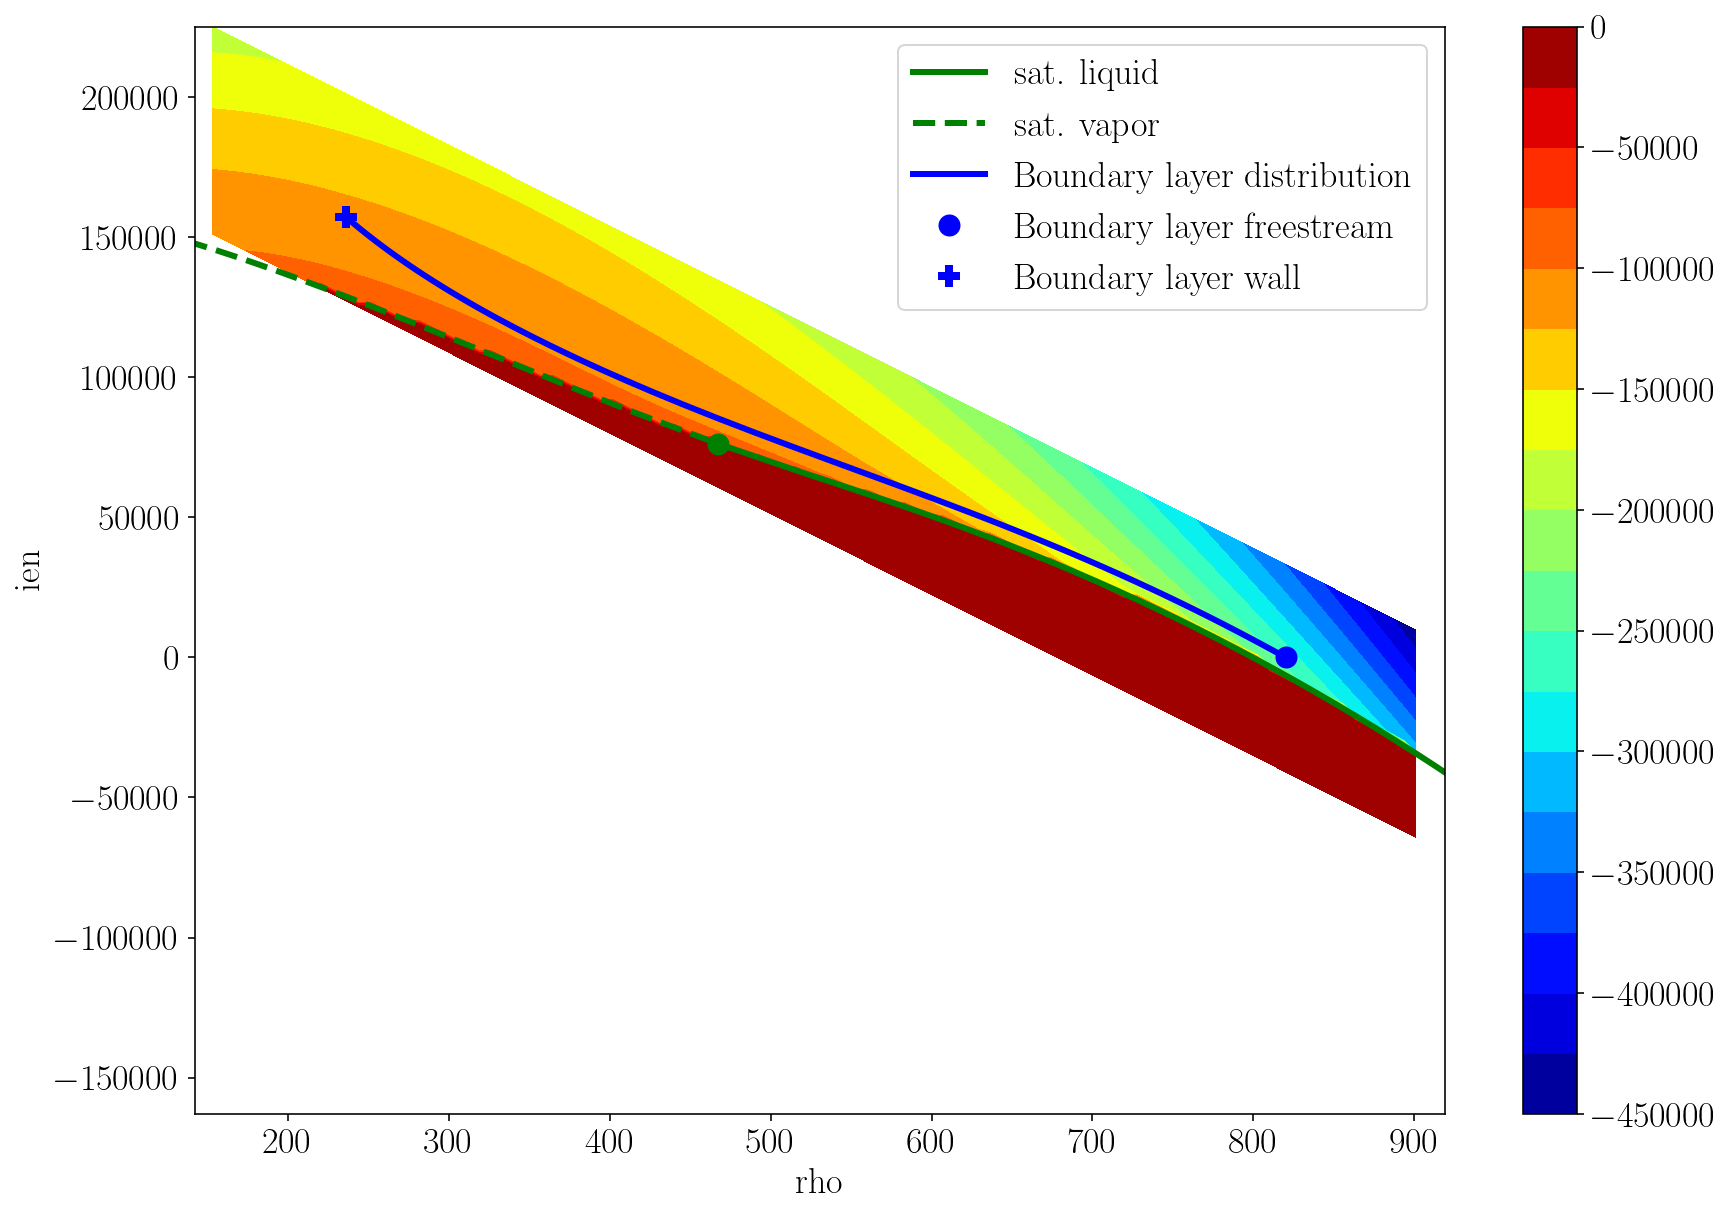

In [49]:
fig, ax = plt.subplots(1,1, figsize=(14,10))
RE_tab.plotTable_RE(fig, ax, params['T_inf'], params['T_wall'], params['P_inf'], RE_tab.der, 0)
# ax.set_xlim((450,500))
# ax.set_ylim((-225000,-120000))

# fig, ax = plt.subplots(1,1, figsize=(14,10))
# RE_tab.plotTable_pv(fig, ax, params['T_inf'], params['T_wall'], params['P_inf'], RE_tab.ien, 1)

# fig, ax = plt.subplots(1,1, figsize=(14,10))
# RE_tab.plotTable_PT(fig, ax, params['T_inf'], params['T_wall'], params['P_inf'], RE_tab.ien, 1)

In [50]:
RE_tab = RE_table(params['fluid'], 
                   Tmin = 280.0, Tmax = 340.0, 
                   Pmin = 60e5,  Pmax = 95e5, 
                   imax = 1000, jmax = 350, jOffset = 175, diagTable = True, e_ref = inf.ien)

rho 2 =  934.898822588244
rho 3 =  119.18271177362612
ien 2 =  -39681.6362421214
ien 3 =  201933.45281148882
errror in tabulating


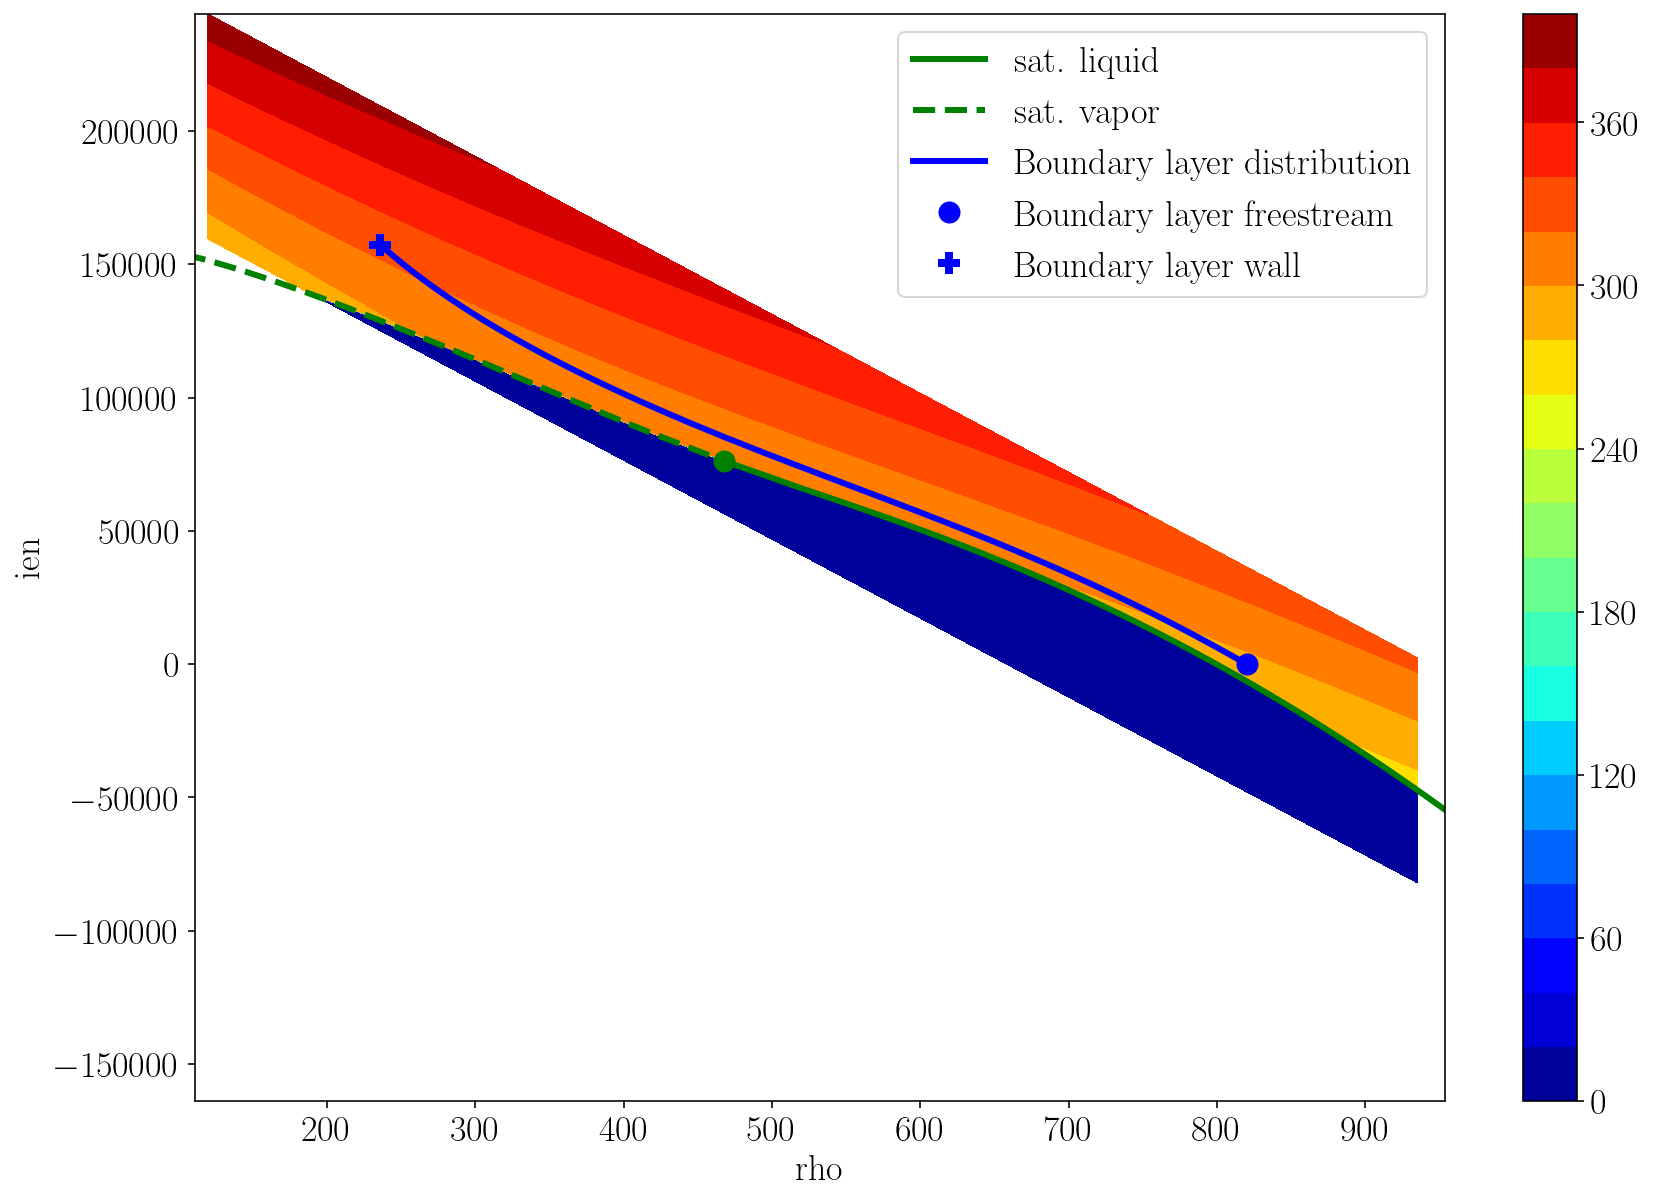

In [51]:
fig, ax = plt.subplots(1,1, figsize=(14,10))
RE_tab.plotTable_RE(fig, ax, params['T_inf'], params['T_wall'], params['P_inf'], RE_tab.tem, 0)

# Case P=80

In [ ]:
params = {'fluid' : 'REFPROP::CO2', 
          'Ec'    : 0.2, 
          'P_inf' : 80.0e5, 
          'T_inf' : 280.0, 
          'T_wall': 326.0077061506552,
          'Re'    : 3153.3474754039753}

inf = refValues(params)

delta_marios =  581922.584743 - CP.PropsSI('U', "D", 83.566473, "T", 500.0, params['fluid'])
print("delta_marios = ", delta_marios)

In [ ]:
# RE_tab = RE_table(params['fluid'], 
#                    Tmin = 270.0, Tmax = 350.0, 
#                    Pmin = 75e5,  Pmax = 90e5, 
#                    imax = 80, jmax = 28, jOffset = 14, diagTable = True, e_ref = -delta_marios)

RE_tab = RE_table(params['fluid'], 
                   Tmin = 270.0, Tmax = 350.0, 
                   Pmin = 75e5,  Pmax = 90e5, 
                   imax = 1000, jmax = 350, jOffset = 175, diagTable = True, e_ref = inf.ien)